# TELCO Customer Churn

## Libraries

In [1]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Optional for imbalanced data
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Plot styling
sns.set(style="whitegrid")


/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Data Details and Structure

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

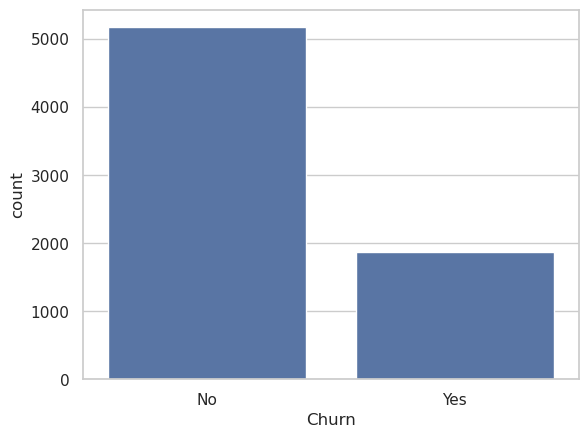

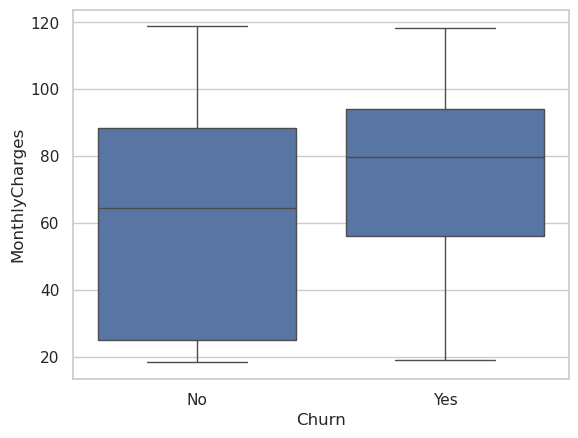

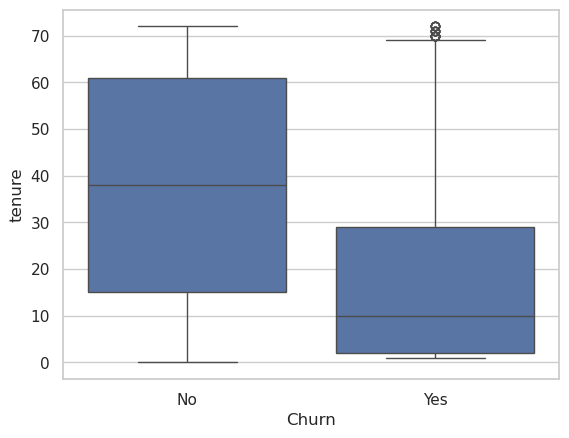

In [3]:
sns.countplot(data=df, x='Churn')
plt.show()

sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.show()

sns.boxplot(data=df, x='Churn', y='tenure')
plt.show()

## Cleaning

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customer ID.Not a predictive feature
df.drop('customerID', axis=1, inplace=True)

/tmp/ipykernel_24607/2546417132.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


## Feature Engineering

* Encode categorical values
* Scale numeric features for models sensitice to scale (e.g., Logistic regression)

In [5]:
cat_cols = df.select_dtypes(include='object').columns.drop('Churn')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode target
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes':1, 'No':0})

# Scaling numerics
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

## Train - Split

In [6]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Helper Function for Evaluation

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC-AUC: {roc:.3f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return {"Accuracy": acc, "F1": f1, "ROC-AUC": roc}

## Base Models

### Logistic Regression

In [8]:
lr = LogisticRegression(max_iter=1000, random_state=42)
print("Logistic Regression (No SMOTE)")
lr_results = evaluate_model(lr, X_train, X_test, y_train, y_test)

Logistic Regression (No SMOTE)
Accuracy: 0.805
F1 Score: 0.603
ROC-AUC: 0.842

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



### Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
print("\nRandom Forest (No SMOTE)")
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test)


Random Forest (No SMOTE)
Accuracy: 0.790
F1 Score: 0.556
ROC-AUC: 0.826

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### XGBoost

In [10]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("\nXGBoost (No SMOTE)")
xgb_results = evaluate_model(xgb_clf, X_train, X_test, y_train, y_test)


XGBoost (No SMOTE)
Accuracy: 0.785
F1 Score: 0.569
ROC-AUC: 0.821

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:28] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Base Models with SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res, = smote.fit_resample(X_train, y_train)
print("Balanced training data:", np.bincount(y_train_res))

Balanced training data: [4139 4139]


### Logistic Regression (SMOTE)

In [12]:
print("\nLogistic Regression (With SMOTE)")
lr_smote_results = evaluate_model(lr, X_train_res, X_test, y_train_res, y_test)


Logistic Regression (With SMOTE)
Accuracy: 0.737
F1 Score: 0.589
ROC-AUC: 0.819

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.50      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409



### Random Forest (SMOTE)

In [13]:
print("\nRandom Forest (With SMOTE)")
rf_smote_results = evaluate_model(rf, X_train_res, X_test, y_train_res, y_test)


Random Forest (With SMOTE)
Accuracy: 0.760
F1 Score: 0.585
ROC-AUC: 0.819

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.54      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.77      1409



### XGBoost (SMOTE)

In [14]:
print("\nXGBoost (With SMOTE)")
xgb_smote_results = evaluate_model(xgb_clf, X_train_res, X_test, y_train_res, y_test)


XGBoost (With SMOTE)
Accuracy: 0.756
F1 Score: 0.586
ROC-AUC: 0.806

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83      1035
           1       0.53      0.65      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.76      1409



/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:30] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Compare Results

Simple dataframe for result comparison

In [15]:
results_df = pd.DataFrame({
    'Model': ['LogReg', 'RandomForest', 'XGBoost'],
    'Accuracy (No SMOTE):': [lr_results['Accuracy'], rf_results['Accuracy'], xgb_results['Accuracy']],
    'Accuracy (SMOTE)': [lr_smote_results['Accuracy'], rf_smote_results['Accuracy'], xgb_smote_results['Accuracy']],
    'F1 (No SMOTE)': [lr_results['F1'], rf_results['F1'], xgb_results['F1']],
    'F1 (SMOTE)': [lr_smote_results['F1'], rf_smote_results['F1'], xgb_smote_results['F1']],
    'ROC-AUC (No SMOTE)': [lr_results['ROC-AUC'], rf_results['ROC-AUC'], xgb_results['ROC-AUC']],
    'ROC-AUC (SMOTE)': [lr_smote_results['ROC-AUC'], rf_smote_results['ROC-AUC'], xgb_smote_results['ROC-AUC']]
})
results_df

,Model,Accuracy (No SMOTE):,Accuracy (SMOTE),F1 (No SMOTE),F1 (SMOTE),ROC-AUC (No SMOTE),ROC-AUC (SMOTE)
0,LogReg,0.804826,0.736693,0.603175,0.589147,0.841995,0.819008
1,RandomForest,0.789922,0.760114,0.555556,0.584767,0.826077,0.819138
2,XGBoost,0.784954,0.755855,0.568990,0.585542,0.821414,0.806214


### Visualize

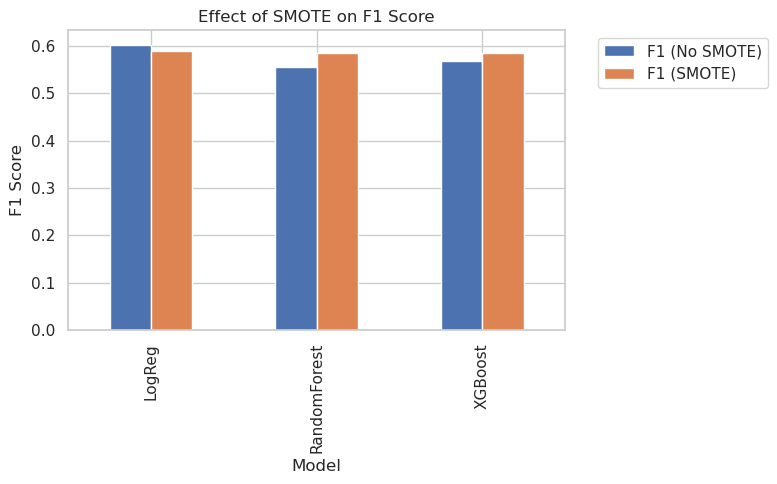

In [16]:
ax = results_df.set_index('Model')[['F1 (No SMOTE)', 'F1 (SMOTE)']].plot(
    kind='bar', figsize=(8,5)
)
plt.title('Effect of SMOTE on F1 Score')
plt.ylabel('F1 Score')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # outside
plt.tight_layout()
plt.show()

## ROC Curves and Confusion Matrices

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

### Helper Functions ROC plots and Confusion Matrices

In [18]:
def plot_roc(model, X_test, y_test, label=None):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

def plot_confusion(model, X_test, y_test, title="Confusion Matrix"):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

### ROC Curves: With vs Without SMOTE

/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:31] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:33] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


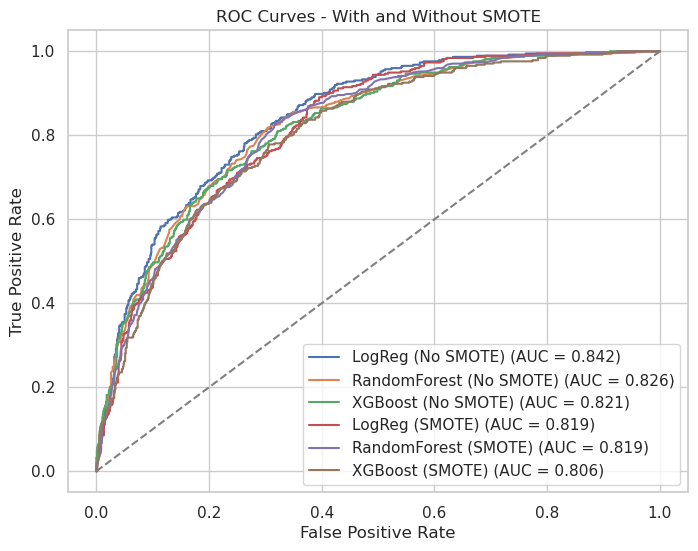

In [19]:
models ={
    "LogReg": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

plt.figure(figsize=(8,6))
for name, model, in models.items():
    model.fit(X_train, y_train)
    plot_roc(model, X_test, y_test, label=f"{name} (No SMOTE)")

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    plot_roc(model, X_test, y_test, label=f"{name} (SMOTE)")

plt.plot([0,1],[0,1], '--',color='gray')
plt.title("ROC Curves - With and Without SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Confusion Matrices

/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:36] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/burak/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:09:36] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


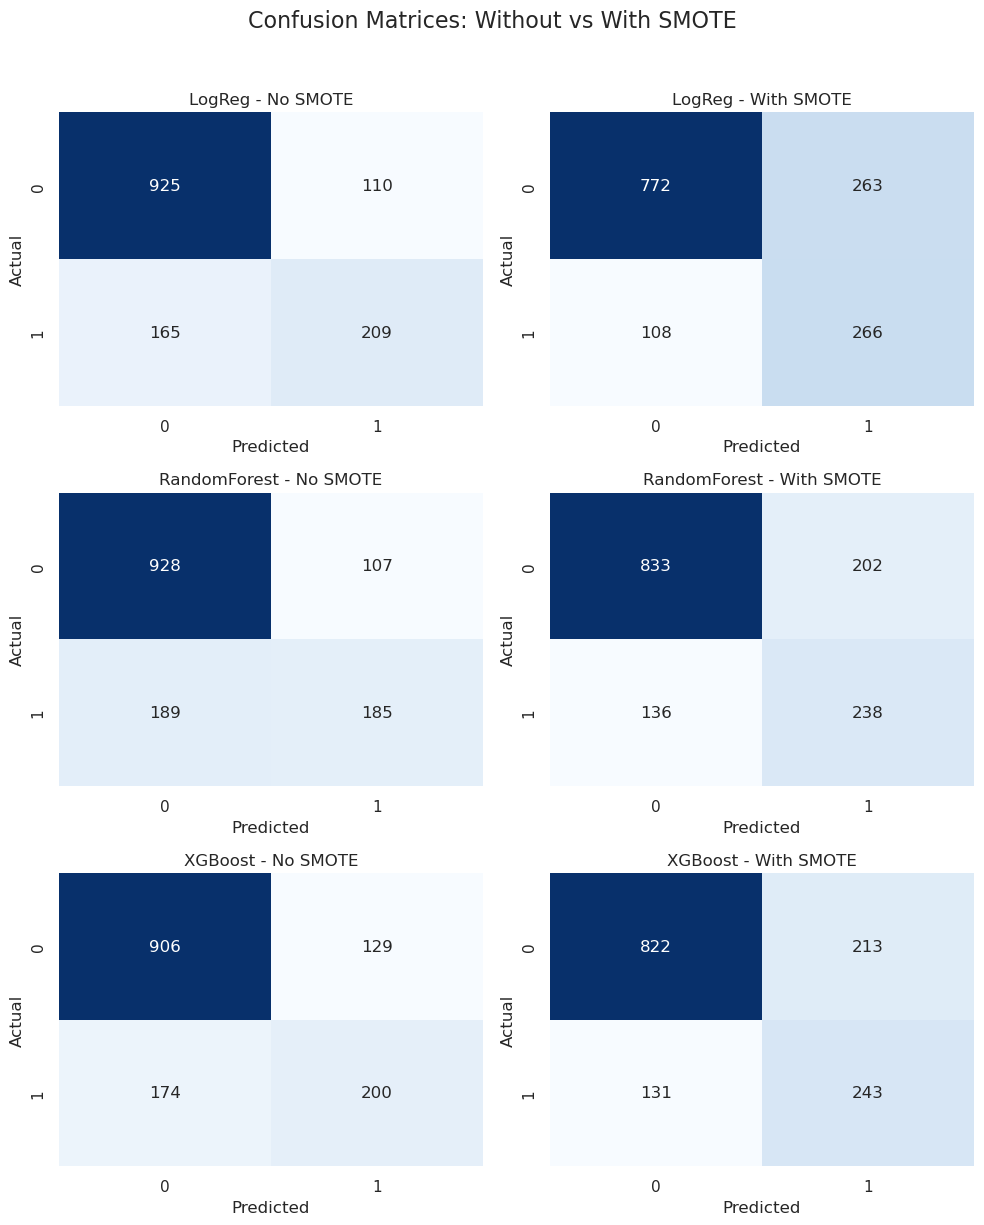

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle("Confusion Matrices: Without vs With SMOTE", fontsize=16, y=1.02)

for i, (name, model) in enumerate(models.items()):
    # Without SMOTE
    model.fit(X_train, y_train)
    plt.sca(axes[i, 0])
    plot_confusion(model, X_test, y_test, title=f"{name} - No SMOTE")

    # With SMOTE
    model.fit(X_train_res, y_train_res)
    plt.sca(axes[i, 1])
    plot_confusion(model, X_test, y_test, title=f"{name} - With SMOTE")

plt.tight_layout()
plt.show()

# Interpretations

## SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method that generates synthetic minority-class samples by interpolating between existing ones. This helps the model learn a better decision boundary and improves detection of churn cases, at the cost of slightly lower accuracy. SMOTE is especially useful when the minority class—such as churners—is the main business interest.

Data set is imbalanced:
* No churn over 5000
* Churn less than 2000

In such a case, model tends to learn **"everyone stays"**.

SMOTE creates artificial customer C halfway between customer A and B.
This gives model:
* More diverse churn examples
* Better decision boundary
* Improved ability to detect minority cases

**Why use SMOTE?**
* Without SMOTE model predicts "No churn" too often
* Recall on churn cases is low
* High accuracy can be misleading

**Downsides of SMOTE**
* It can reduce accuracy
* Introduce noisy samples
* Linear models (e.g., Logistic Regression) may perform worse.
* Works better with tree-based models (RF, XGBoost, LightGBM)

**Test results of this notebook clearly reflects this case.**

**With SMOTE**
* Model is more sensitive to churn
* F1 score improves
* Recall increaes
* Model becomes more balanced

**This is important in cases where minority class is important.**

## Findings and Takeaways

### Accuracy Dropped with SMOTE

Across all models, Accuracy went down after applying SMOTE.
This is totally expected:

**SMOTE adds synthetic churn cases, making the model more sensitive to churn, but also increases false positives → lowering accuracy.**

In churn prediction, this is a good trade-off, because, catching more real churners is usually more important than occasionally flagging a loyal customer by mistake.

### F1 Score improved for tree-based models
* **Random Fores:** 0.556 -> 0.585
* **XGBoost:** 0.569 -> 0.586

SMOTE helped the models detect churn better without compromising precision.

### Logistic Regression did not benefit
* F1 slightly dropped: 0.603 -> 0.589
* ROC-AUC slightly dropped: 0.842 -> 0.819

Logistic regression is sensitive to noise. SMOTE creates synthetic linear boundaries that can interfere with simple linear classifier.

This was expected.

### ROC-AUC remained consistent
All values remained around 0.80-0.84 which means:

Models are good at ranking churners higher than non.churners, with or whitout SMOTE
This indicates features truly contain predictive signal.

## Why SMOTE Can Hurt Logistic Regression

### Logistic Regression assumes linear decision boundary
Logistic regression tries to draw a **straight line** that separates classes.

But SMOTE interpolates between minority samples in all directions, even if real boundary is not linear.

Result:
* SMOTE may create synthetic churn samples in regions where real churn cases don't naturally occur.
* Logistic regression tries to fit a line through this new noisy cloud.
* Linear boundary becomes **worse**.

### SMOTE creates "blurry" minority samples
Tree-based models (RF, XGBoost) dont'care - they split space into small boxes

But Logistic Regression:
* Needs clean, well-separated classes
* Sensitive to mislabeled or artificial points
* Its coefficients shiuft in suboptimal directions

  Synthetic poins -> noisy linear boundary -> reduced performance

### Linear models don't adapt well to synthetic overlap
When SMOTE generates new minority points near majority class, Logistic Regression sees more overlap between classes.

More overlap -> harder to find clean linear separation -> lower F1 and ROC-AUC.

Tree-based models are fine with messy overlap; linear models are not

### SMOTE equalizes classes
When classes are artificially balanced:
* Shifts the intercept
* Distorts probability estimates
* Affects decision thresholding

### Logistic Regression is sensitive to multicollinearity
SMOTE can make correlated features more correlated because synthetic  samples are linear combinations of neightbours.

More multicollinearity -> unstable logistic regression -> weaker generalization

Trees are not affected by this